#14_CNN_CNN모델클래스화 Version 2

###ML 라이브러리: Pytorch(GPU)

In [1]:
import torch
import torchvision.datasets as data
import torchvision.transforms as transforms
import random

GPU 사용을 명시적으로 보여주기 & Random Seed 고정하기

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

학습 파라미터 설정

In [3]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

##1. 데이터셋 불러오기

In [4]:
mnist_train = data.MNIST(root = 'MNIST_data/', train = True, transform = transforms.ToTensor(), download = True)

mnist_test = data.MNIST(root = 'MNIST_data/', train = False, transform = transforms.ToTensor(), download = True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw




Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw




Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


DataLoader: 데이터를 알맞게 나눠준다

In [5]:
data_loader = torch.utils.data.DataLoader(dataset = mnist_train, batch_size = batch_size, shuffle = True, drop_last = True)
#dataset = mnist_train: 처리할 데이터
#batch_size = batch_size: batch_size만큼씩 데이터를 잘라러 준다
#shuffle = True: 데이터를 섞는다
#drop_last: 모든 데이터 개수 % batch_size > 0 일 때 나머지 데이터를 버린다

##5. 모델 추정

###모델 정의: CNN 모델 클래스화 Version 2

CNN 모델 클래스화 Version 2

In [6]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.fc = torch.nn.Linear(7*7*64, 10, bias = True)
        torch.nn.init.kaiming_uniform(self.fc.weight)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)

        # out = Batch(0) x 7(1) x 7(2) x 64(3) 
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

CNN 모델 클래스 호출

In [7]:
model = CNN().to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


###모델 학습

Cross Entropy Loss & Adam Optimizer

In [8]:
loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

"14_CNN_01_DNN모델클래스화" 예제와 동일하지만 X 데이터를 View로 변환하는 부분이 다르다<br>
주의: 2D -> 1D로 변환할 필요 없다

In [9]:
total_batch = len(data_loader)

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: #앞에서 알맞게 나눠둔 데이터를 X, Y에 넣어준다

        # 2D 데이터를 1D 데이터로 눌러줄 필요 없다
        # One-hot Encoding되어 있지 않다
        X= X.to(device)
        Y = Y.to(device)

        # Gradient Initialization
        optimizer.zero_grad()

        # Forward 계산
        hypothesis = model(X)

        # Cost : Error 계산
        cost = loss(hypothesis, Y)

        # Backpropagation
        cost.backward()

        # Cost로 가중치(W, b) 갱신
        optimizer.step()

        # 평균 Error 계산
        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:>.9f}'.format(avg_cost))

print('Learning Finished')

Epoch: 0001 cost = 0.220295355
Epoch: 0002 cost = 0.061010364
Epoch: 0003 cost = 0.046022985
Epoch: 0004 cost = 0.036710277
Epoch: 0005 cost = 0.029989691
Epoch: 0006 cost = 0.026255384
Epoch: 0007 cost = 0.020755304
Epoch: 0008 cost = 0.018718481
Epoch: 0009 cost = 0.015415019
Epoch: 0010 cost = 0.013164530
Epoch: 0011 cost = 0.011687442
Epoch: 0012 cost = 0.008648576
Epoch: 0013 cost = 0.008347776
Epoch: 0014 cost = 0.006705801
Epoch: 0015 cost = 0.006646133
Learning Finished


##6. 결과 분석

Accuracy

In [10]:
#앞서 모델 학습 과정에서는 required_grad = True로 되어있어 학습 중임을 나타낸다
#False는 학습 중이 아님을, 모델 평가 중임을 나타낸다

#주의: 2D -> 1D로 변환할 필요 없다

with torch.no_grad(): #임시로 required_grad = False로 설정하는 것과 같다

  # DNN: X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
  # 2D 데이터를 1D 데이터로 눌러줄 필요 없다
  X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
  Y_test = mnist_test.test_labels.to(device)

  prediction = model(X_test)

  correct_prediction = torch.argmax(prediction, 1) == Y_test

  accuracy = correct_prediction.float().mean()

  print('Accuracy:', accuracy.item())

Accuracy: 0.9855999946594238


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Random Test: 한 데이터만

In [11]:
r = random.randint(0, len(mnist_test) - 1)
X_single_data = mnist_test.test_data[r:r + 1].view(1, 1, 28, 28).float().to(device) #주의: 2D -> 1D로 변환할 필요 없다
Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

print('Label: ', Y_single_data.item())
single_prediction = model(X_single_data)
print('Prediction: ', torch.argmax(single_prediction, 1).item())

Label:  8
Prediction:  8


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Random Test한 데이터 시각화하기

tensor([8], device='cuda:0')


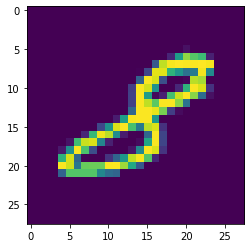

In [12]:
import matplotlib.pyplot as plt
plt.imshow(X_single_data.reshape(28,28).cpu()) # 1D -> 2D
print(Y_single_data)